# ephax Quickstart Tutorial

Welcome! This notebook walks through a minimal workflow for the analyzer-first electrophysiology toolkit. You'll learn how to prepare a dataset, choose reference electrodes, and run a few of the provided analyzers on synthetic data.

## Prerequisites

- Python 3.9+ with Jupyter installed (`pip install jupyterlab`)
- The `ephax` package available in your environment (`pip install -e .` from the repository root)
- MEA spike recordings in `.h5` or `.npz` form — we will start with a synthetic dataset you can run anywhere

In [1]:

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from ephax import RestingActivityDataset, PrepConfig, Recording
from ephax.analyzers import IFRAnalyzer
from ephax.analyzers.ifr import IFRConfig
from ephax.analyzers.firing_distance import FiringDistanceAnalyzer
from ephax.analyzers.cofiring_temporal import CofiringTemporalAnalyzer, CofiringTemporalConfig
from ephax import LayoutGridPlotter
from ephax import DCTAnalyzer
plt.rcParams["figure.dpi"] = 120
np.random.seed(0)

## Working with Your Own Recordings

Replace the synthetic dataset with real recordings by preparing a `file_info` list and calling `RestingActivityDataset.from_file_info`:

```python
file_info = [
    ("ephax/data", "well_0.raw.h5", 0, 600, 0),  # (folder, filename, start time (s), end time (s), well number)
    ("ephax/data", "well_1.raw.h5", 0, 600, 1),
]
ds = RestingActivityDataset.from_file_info(file_info, source="h5", min_amp=0)
```

After loading, keep the rest of the notebook unchanged: reuse `PrepConfig`, instantiate analyzers, and iterate on configuration parameters as needed. Consult `README.md` for additional analyzers (stability, DCT, GIF generation) and advanced options such as permutation controls.

### Bundled Example Recordings

The repository ships with short `.raw.h5` snippets under `ephax/data`. Load them by pointing `file_info` at that folder:

If you launch Jupyter from elsewhere, adjust `repo_root` accordingly or provide absolute paths in `file_info`.


In [2]:
from pathlib import Path
from ephax import RestingActivityDataset

repo_root = Path.cwd()  # run the notebook from the repository root
file_info = [
    ("ephax/data", "well_0.raw.h5", 0, 600, 0),
    ("ephax/data", "well_1.raw.h5", 0, 600, 1),
    ("ephax/data", "well_2_3.raw.h5", 0, 600, 2),
    ("ephax/data", "well_2_3.raw.h5", 0, 600, 3),
    ("ephax/data", "well_4.raw.h5", 0, 600, 4),
    ("ephax/data", "well_5.raw.h5", 0, 600, 5),
]

def resolve(entry):
    folder, filename, start, end, well = entry
    folder_path = repo_root / folder
    return (folder_path.as_posix(), filename, start, end, well)

resolved_info = [resolve(item) for item in file_info]
ds = RestingActivityDataset.from_file_info(resolved_info, source="h5", min_amp=0)

## Selecting Reference Electrodes with `PrepConfig`

Analyzers expect a list of reference electrodes per recording. `PrepConfig` lets you request them by activity threshold, by rank, or by providing an explicit list. Here we pick the top 30 most active electrodes within each recording window.

In [3]:

top_stop = 100 # select top 100 most active electrodes as references

prep_cfg = PrepConfig(mode="top", top_start=0, top_stop=top_stop, verbose=False)
refs_per_recording = ds.select_ref_electrodes(prep_cfg)
for idx, refs in enumerate(refs_per_recording):
    preview = ", ".join(map(str, refs[:5])) + ("…" if refs.size > 5 else "")
    print(f"Recording {idx}: selected {refs.size} reference electrodes ({preview})")


Recording 0: selected 100 reference electrodes (20712, 24210, 12336, 4376, 20918…)
Recording 1: selected 100 reference electrodes (25596, 10865, 4204, 7679, 19106…)
Recording 2: selected 100 reference electrodes (14466, 9635, 12110, 23342, 23806…)
Recording 3: selected 100 reference electrodes (25095, 18729, 18276, 3978, 4020…)
Recording 4: selected 100 reference electrodes (1335, 11459, 10819, 9635, 11715…)
Recording 5: selected 100 reference electrodes (14020, 13801, 22701, 14021, 21083…)


## Instantaneous Firing Rate (IFR) Analysis

`IFRAnalyzer` pools spikes across recordings, computes instantaneous firing rate samples, optionally fits a Gaussian mixture model, and can render per-recording heatmaps. We reuse our `PrepConfig` so the analyzer focuses on the same reference electrodes.

In [5]:

ifr_cfg = IFRConfig(log_scale=True, hist_bins=60, overlay_gmm=True, time_grid_hz=200.0, max_time_points=2_000)
ifr_analyzer = IFRAnalyzer.from_dataset(ds, config=ifr_cfg, selection_prep_config=prep_cfg)
peaks = ifr_analyzer.peaks()
print(f"Collected {peaks.values.size} IFR samples")
if peaks.peaks_hz.size:
    print("GMM peak locations (Hz):", np.round(peaks.peaks_hz, 2))
else:
    print("No peaks detected — consider widening the selection window.")


Collected 368158 IFR samples
GMM peak locations (Hz): [2.4000e-01 6.9600e+00 4.9540e+01 1.8652e+02 5.9495e+02]


(<Figure size 1200x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Gaussian Mixture Model Fit to IFR Data'}, xlabel='Log(IFR)', ylabel='Density'>)

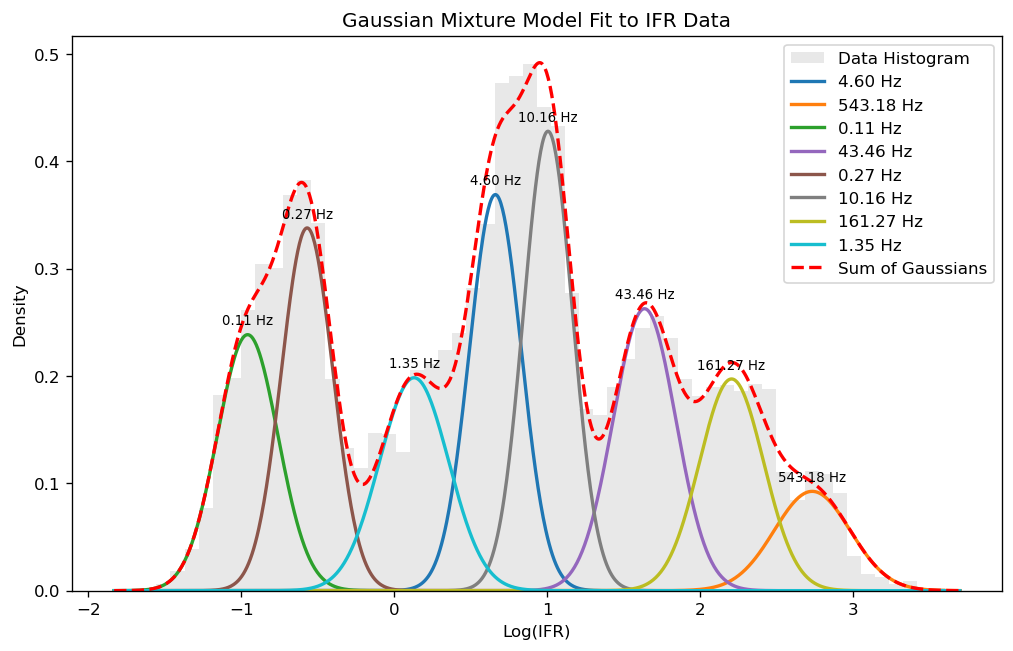

In [6]:

ifr_analyzer.plot_histogram()


[(<Figure size 1440x960 with 3 Axes>,
  (<AxesSubplot:title={'center':'Log Instantaneous Firing Rate Across Top 100 electrodes'}, xlabel='Time (s)', ylabel='Channel by Firing Frequency Rank'>,
   <AxesSubplot:title={'center':'Histogram of Instantaneous Firing Rates'}, xlabel='Log Instantaneous Firing Rate (Hz)', ylabel='Frequency'>)),
 (<Figure size 1440x960 with 3 Axes>,
  (<AxesSubplot:title={'center':'Log Instantaneous Firing Rate Across Top 100 electrodes'}, xlabel='Time (s)', ylabel='Channel by Firing Frequency Rank'>,
   <AxesSubplot:title={'center':'Histogram of Instantaneous Firing Rates'}, xlabel='Log Instantaneous Firing Rate (Hz)', ylabel='Frequency'>)),
 (<Figure size 1440x960 with 3 Axes>,
  (<AxesSubplot:title={'center':'Log Instantaneous Firing Rate Across Top 100 electrodes'}, xlabel='Time (s)', ylabel='Channel by Firing Frequency Rank'>,
   <AxesSubplot:title={'center':'Histogram of Instantaneous Firing Rates'}, xlabel='Log Instantaneous Firing Rate (Hz)', ylabel='Freq

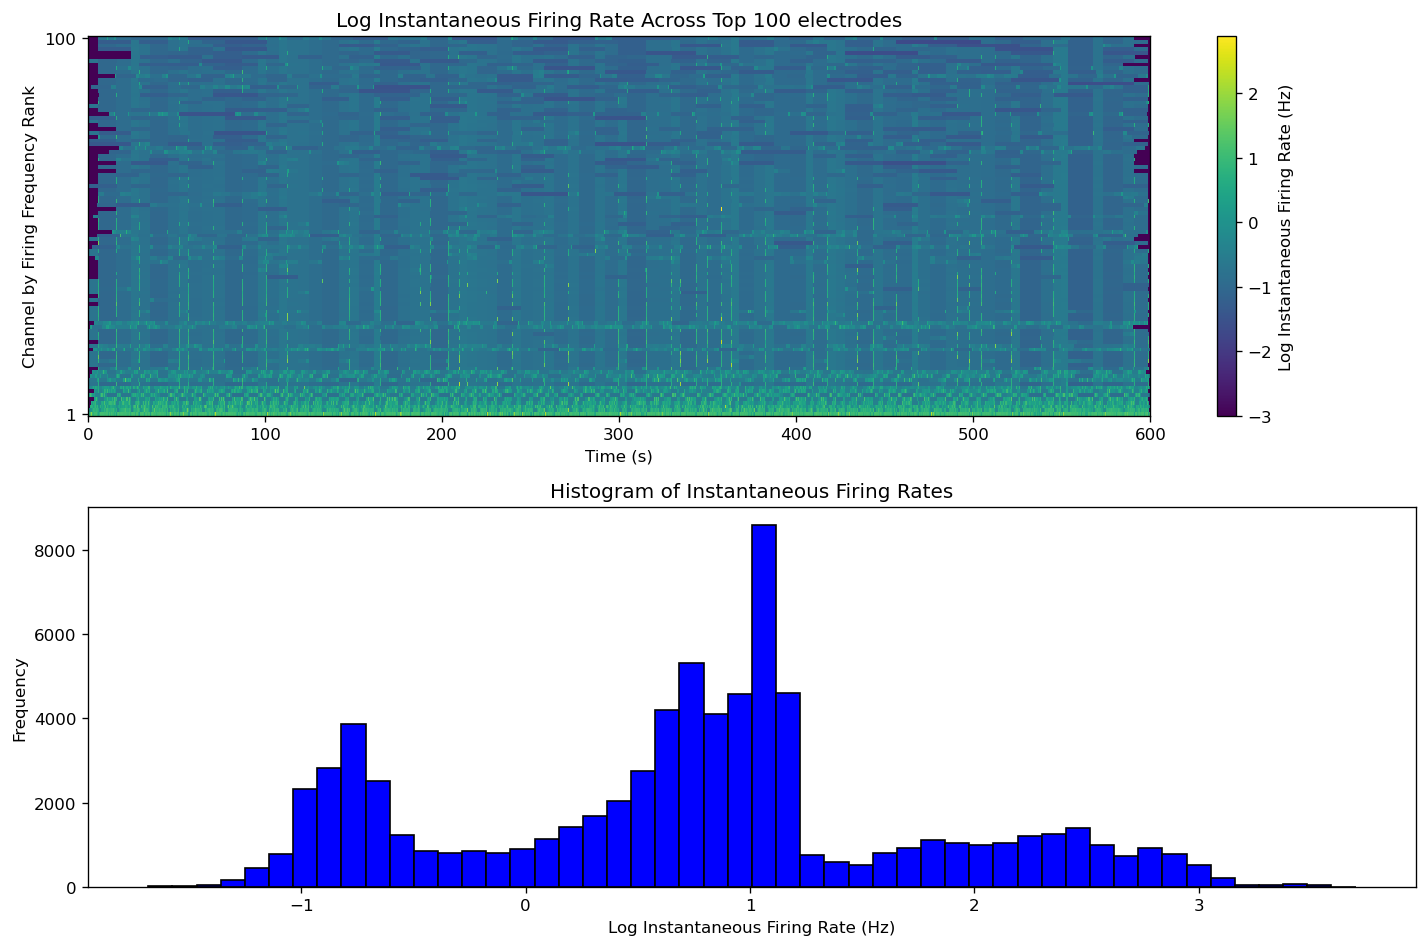

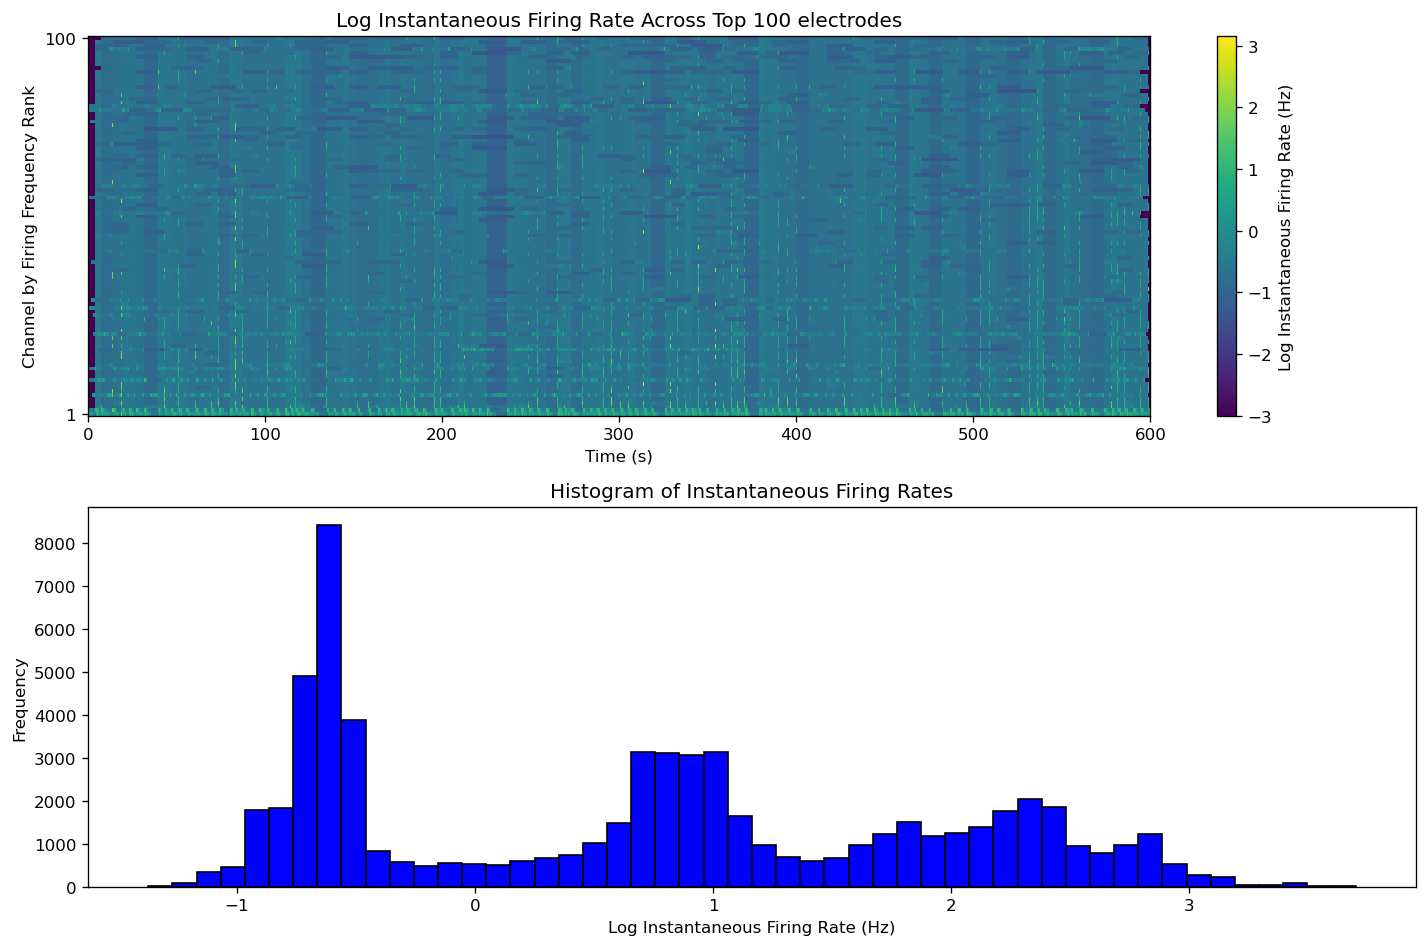

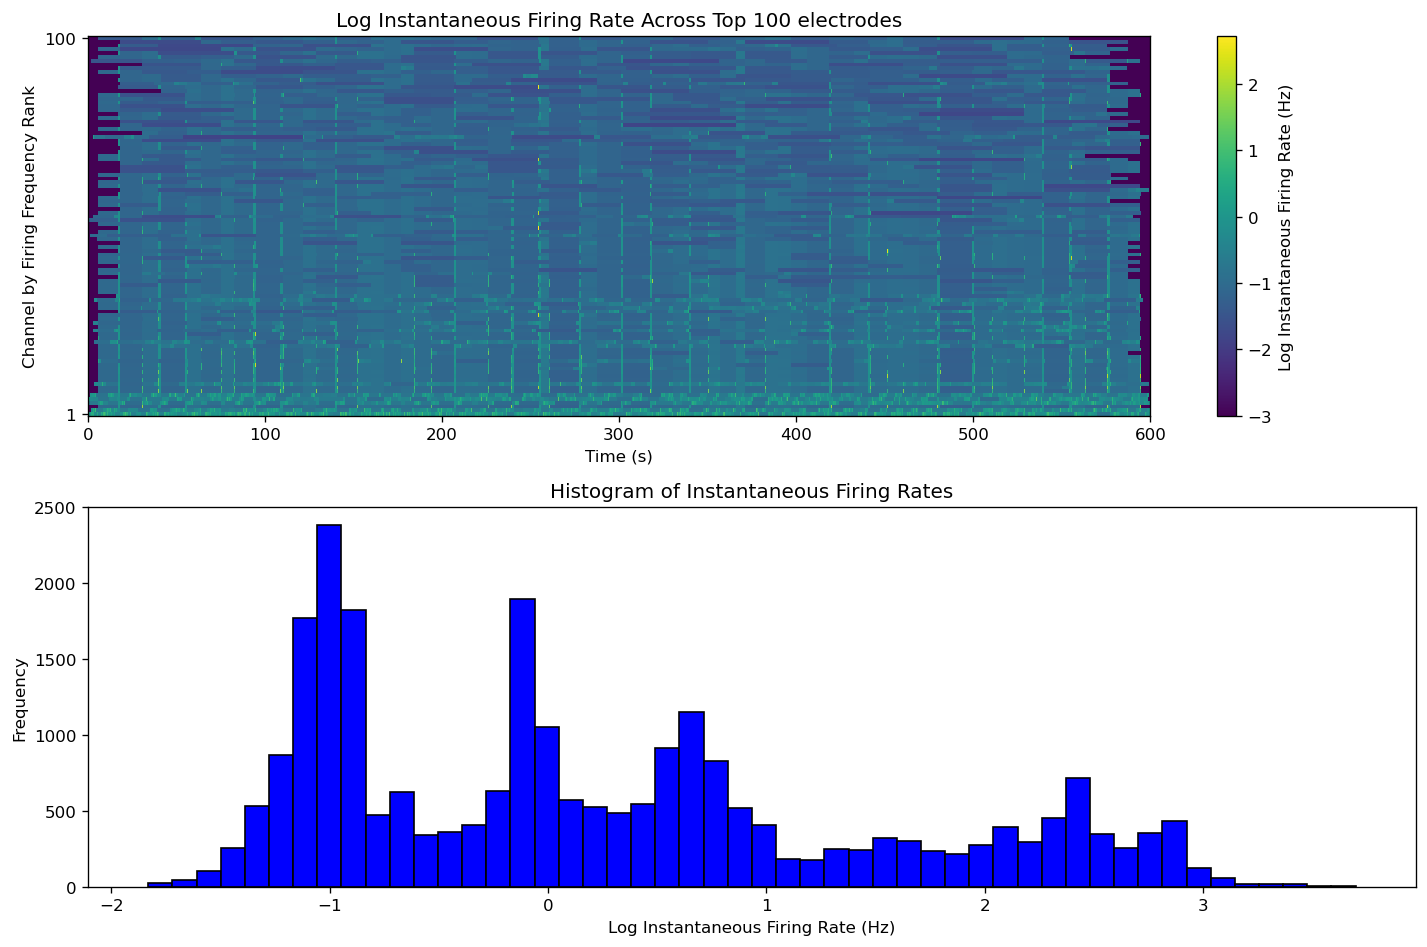

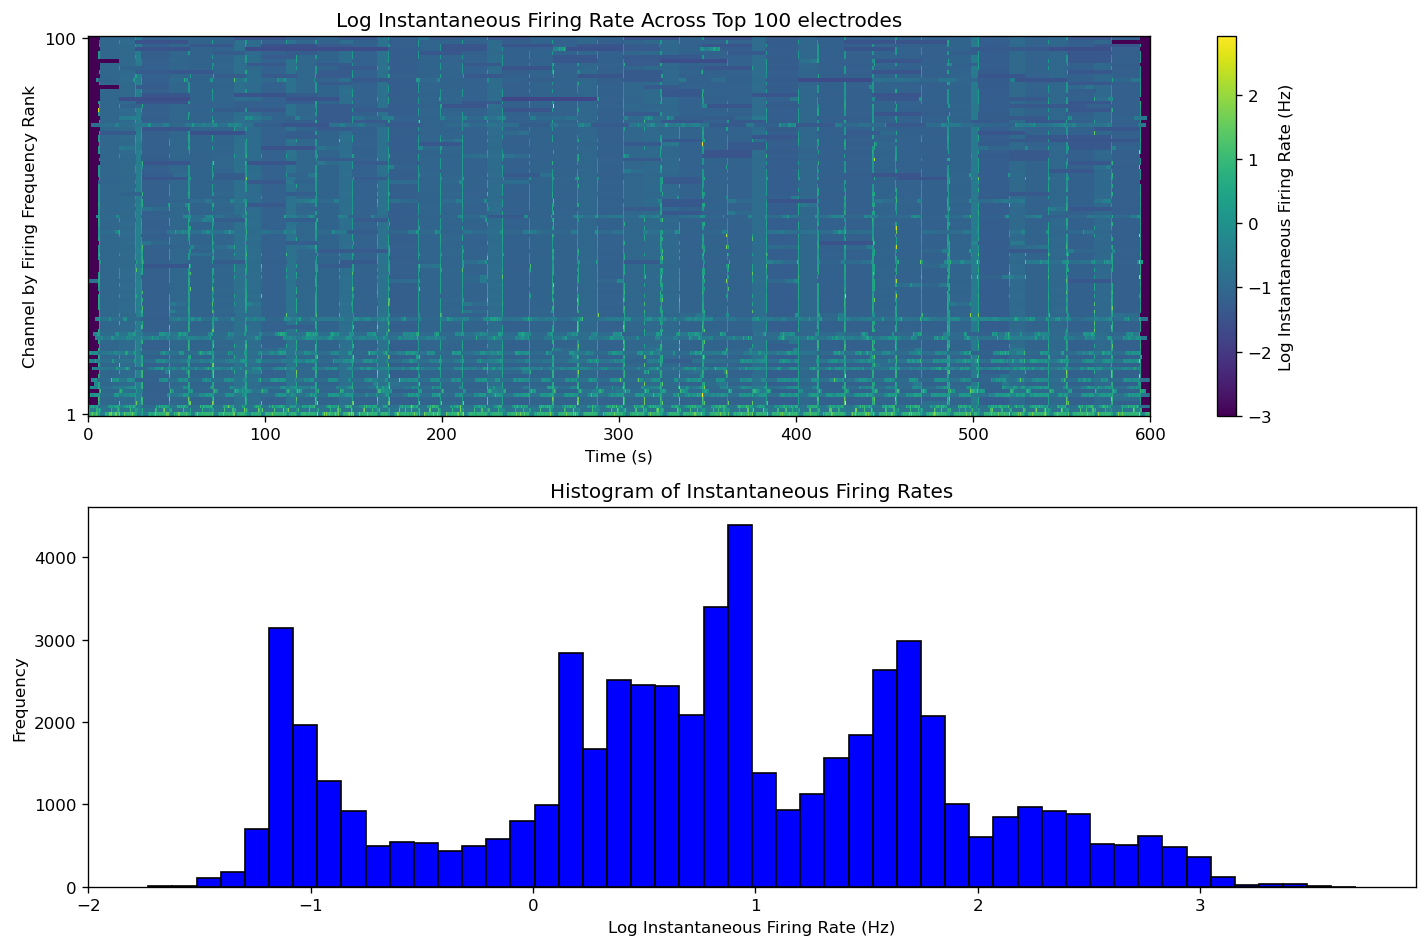

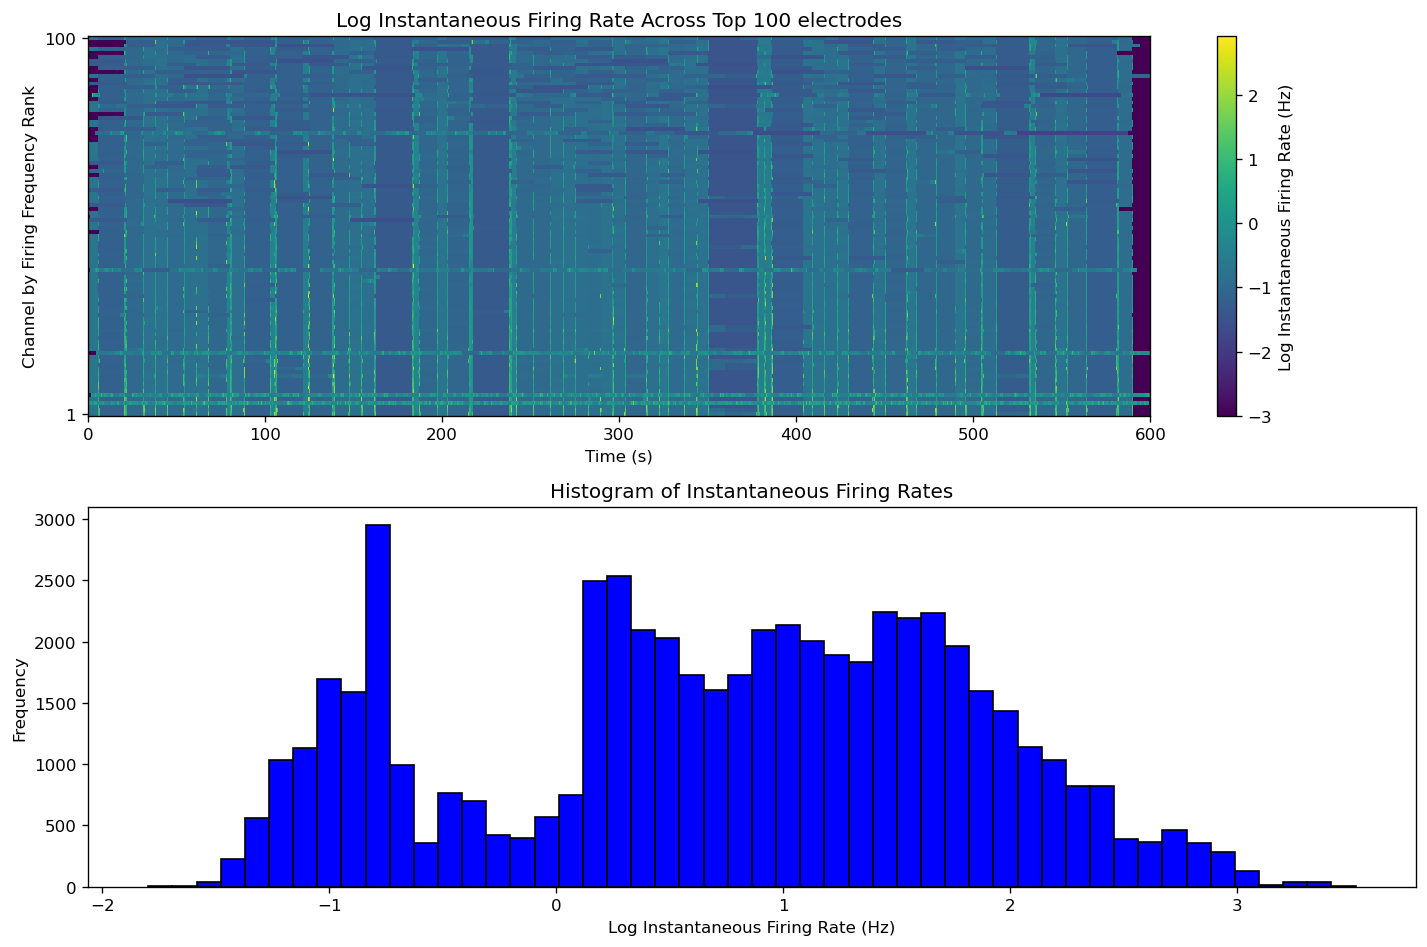

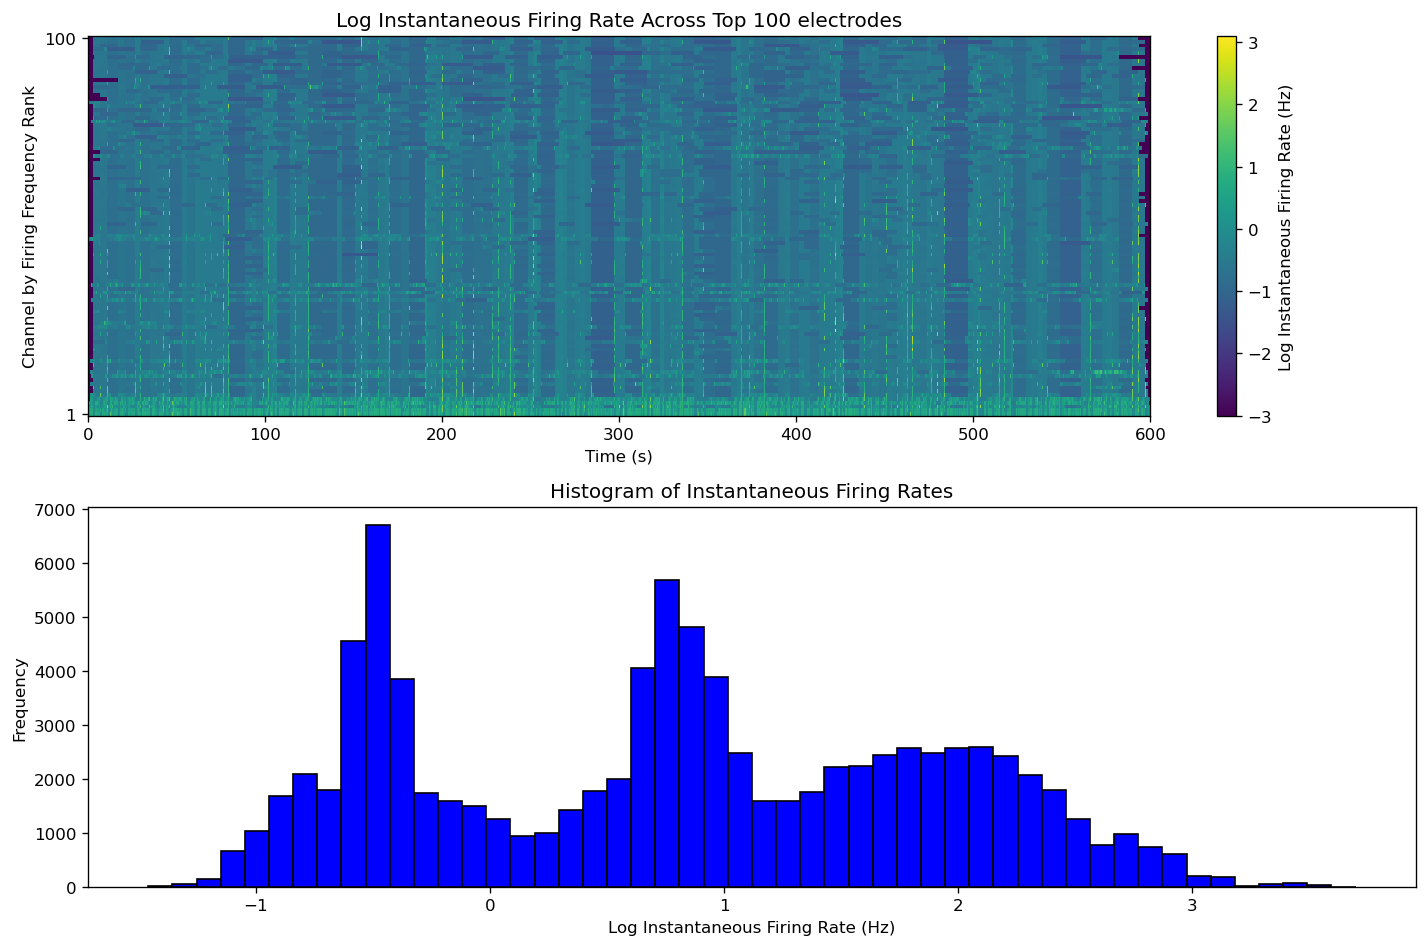

In [7]:

ifr_analyzer.plot_timeseries()


In [8]:
shuffle_layout_coordinates = True  # Also randomize physical coordinates across electrodes
permute_for_null = True
num_permutations = 2
perm_seed = 12345
perm_datasets: list[RestingActivityDataset] = []
if permute_for_null:
    for perm_idx in range(num_permutations):
        permuted_recs = []
        for rec_idx, rec in enumerate(ds.recordings):
            if perm_seed is None:
                seed = None
            else:
                seed = perm_seed + perm_idx * 1000 + rec_idx
            permuted_recs.append(
                rec.randomize_electrode_mapping(
                    seed=seed,
                    inplace=False,
                    shuffle_layout_coordinates=shuffle_layout_coordinates,
                )
            )
        perm_datasets.append(RestingActivityDataset(recordings=permuted_recs, sf=ds.sf))

## Distance-Dependent Firing Statistics

`FiringDistanceAnalyzer` aggregates firing or co-firing metrics as a function of inter-electrode distance. You can inspect whether firing rates decay with distance, and overlay the theoretical synergy curve derived from the detected IFR peaks.


[Rate] Synergy model summary:
  Model (43.5, 161.3, 543.2 Hz): logL=-10601.5896, BIC=-4751.9702, MI=1.46809
  Model (43.5, 161.3 Hz): logL=-10752.0402, BIC=-4760.7951, MI=1.57317
  Model (43.5 Hz): logL=-17190.2063, BIC=-4777.1436, MI=1.66155
[Rate] Likelihood-ratio tests vs full model:
  Model (43.5, 161.3 Hz): LRT=300.9013, p=2.096e-67
  Model (43.5 Hz): LRT=13177.2335, p=0.000e+00
ANOVA F-statistic: 0.012490321938045322, p-value: 0.9875874097876967


(<Figure size 1200x1440 with 3 Axes>,
 <AxesSubplot:title={'center':'Averaged Firing Rate vs. Distance with First Signal Synergy Peaks'}, xlabel='Distance from Electrode ($\\mu m$)', ylabel='Mean Firing Rate (Hz)'>)

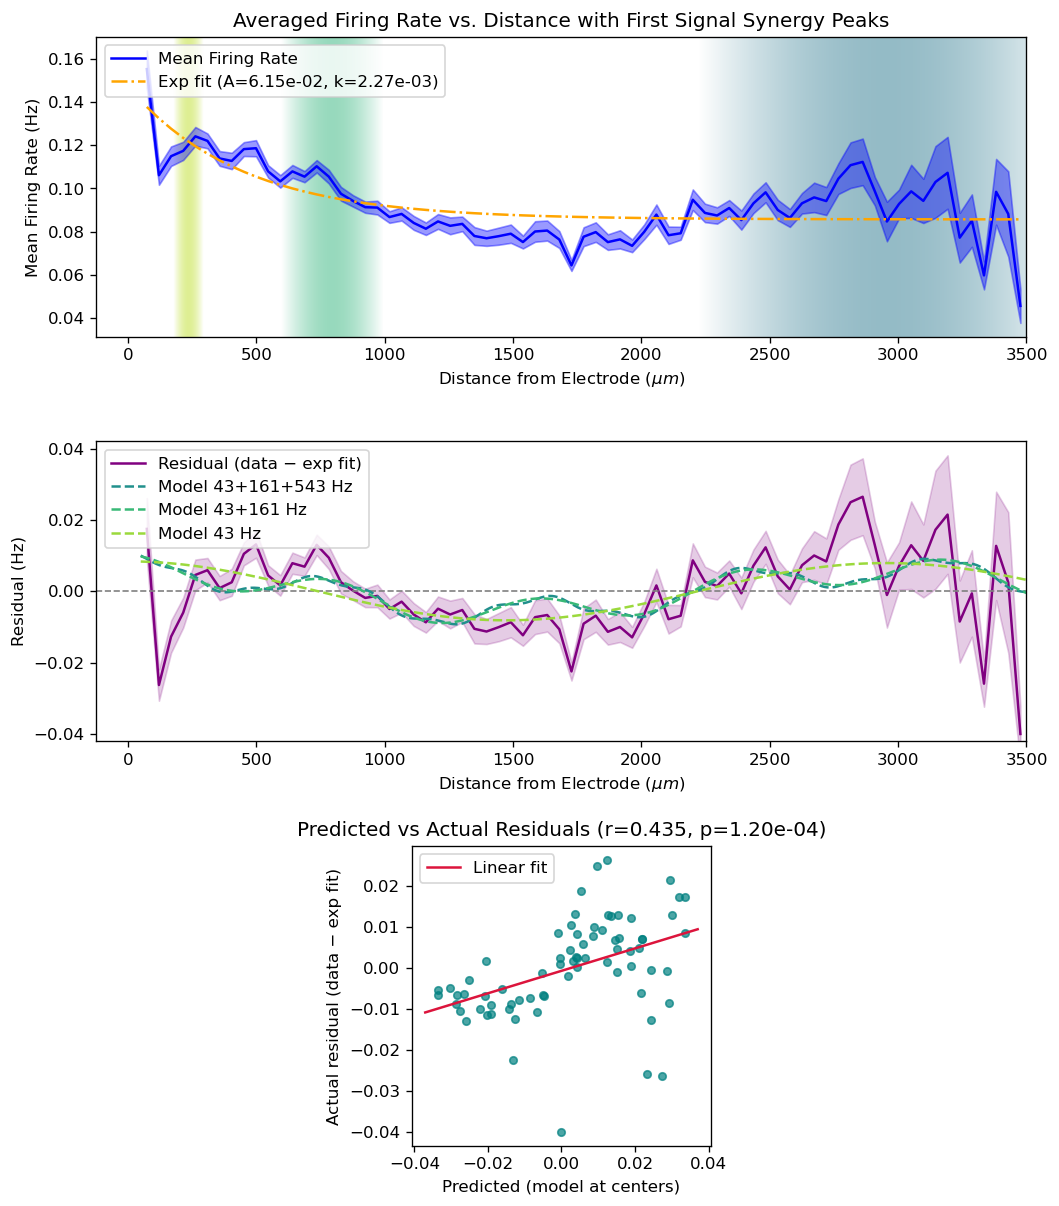

In [ ]:

fd_perm_dataset = perm_datasets[0] if perm_datasets else None
fd_analyzer = FiringDistanceAnalyzer(
    ds,
    dataset_perm=fd_perm_dataset,
    selection_prep_config=prep_cfg,
    v_eph=0.1,
    v_ax=0.45,
)
plusminus_ms = 2.0 # co-firing window half-width

# Co-firing vs distance with synergy overlay
rate_vs_distance = fd_analyzer.avg_rate_vs_distance()
fd_analyzer.plot_rate_with_synergy(rate_vs_distance, show_exponential_fit=True)
# Co-firing vs distance with synergy overlay
cof_res = fd_analyzer.cofiring_avg_vs_distance(plusminus_ms=plusminus_ms, log=False)
fd_analyzer.plot_cofiring_with_synergy(cof_res)


## Temporal Co-firing Heatmap

`CofiringTemporalAnalyzer` summarizes how co-firing probability changes with inter-electrode distance and temporal delay. The visualization below averages across reference electrodes and recordings using the same selection we defined earlier.

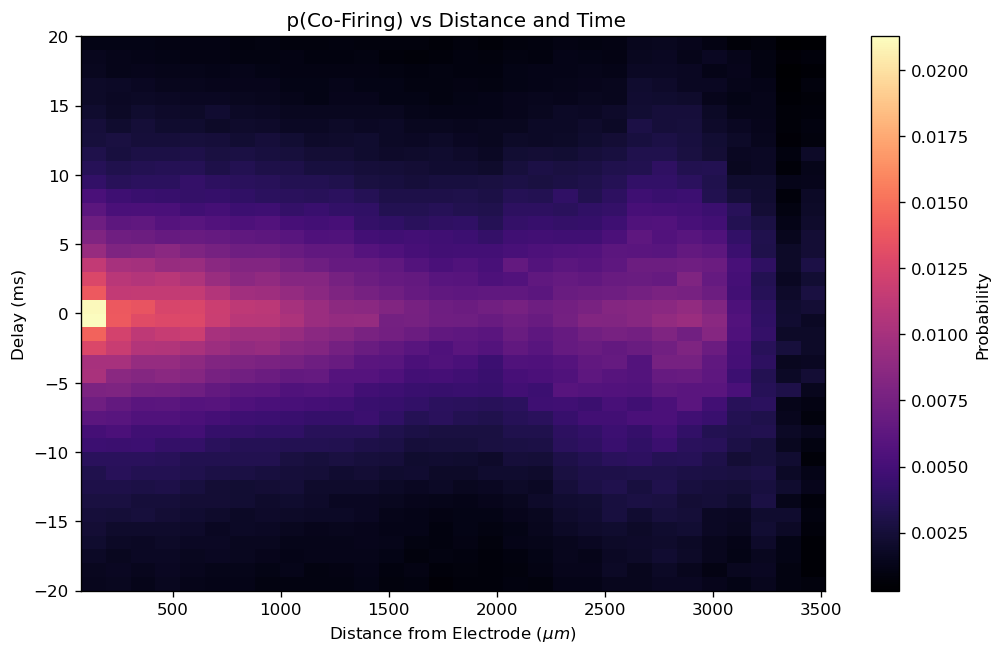

(<Figure size 1200x720 with 2 Axes>,
 <AxesSubplot:title={'center':' p(Co-Firing) vs Distance and Time'}, xlabel='Distance from Electrode ($\\mu m$)', ylabel='Delay (ms)'>)

In [11]:

cft_cfg = CofiringTemporalConfig(start_ms=-20, stop_ms=20, step_ms=1, normalize=False)
cft_analyzer = CofiringTemporalAnalyzer(ds, cft_cfg, selection_prep_config=prep_cfg)
cft_analyzer.plot_avg_cofiring_heatmap()

### Temporal Co-firing GIFs (Optional)

Use the same dataset and reference selection to generate temporal co-firing summaries beyond the quick heatmap. GIF creation can take a while on full recordings, so start with a subset if you are experimenting.

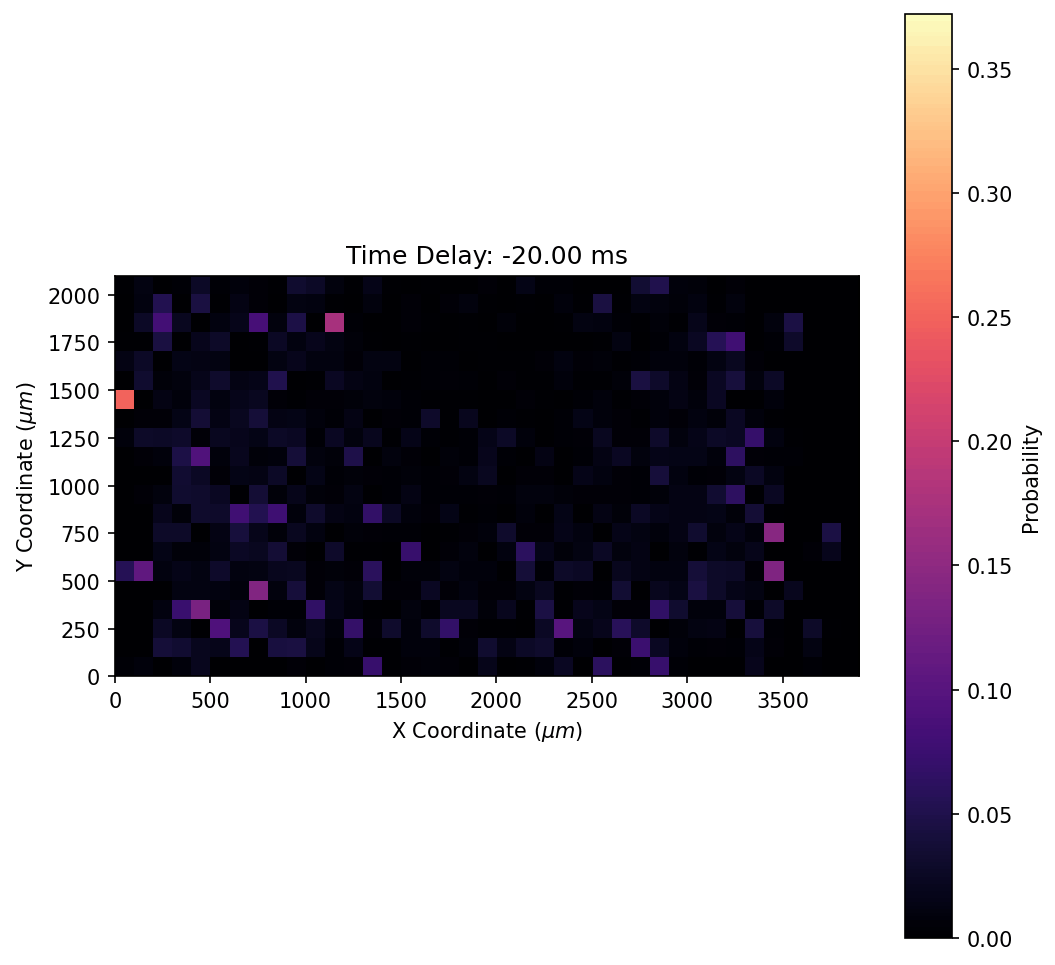

In [ ]:
from IPython.display import Image, display

# Temporal co-firing analyses (averaged heatmap + GIFs)
cfcfg = CofiringTemporalConfig(start_ms=-20, stop_ms=20, step_ms=4, normalize=False)
cfa = CofiringTemporalAnalyzer(ds, cfcfg, selection_prep_config=prep_cfg)

# cfa.plot_avg_cofiring_heatmap()  # ~15 minutes on all bundled files
# cfa.create_theta_gif(output_filename='cofiring_theta_all.gif')
# display(Image(filename="cofiring_grid_all.gif"))

cfa.create_grid_gif(output_filename='cofiring_grid_all.gif')
display(Image(filename="cofiring_grid_all.gif"))



### Layout Grid Visualizations

`LayoutGridPlotter` interpolates spike statistics onto a spatial grid so you can inspect firing hotspots across the array. The pooled plot averages across recordings, while the panel view provides per-recording snapshots.

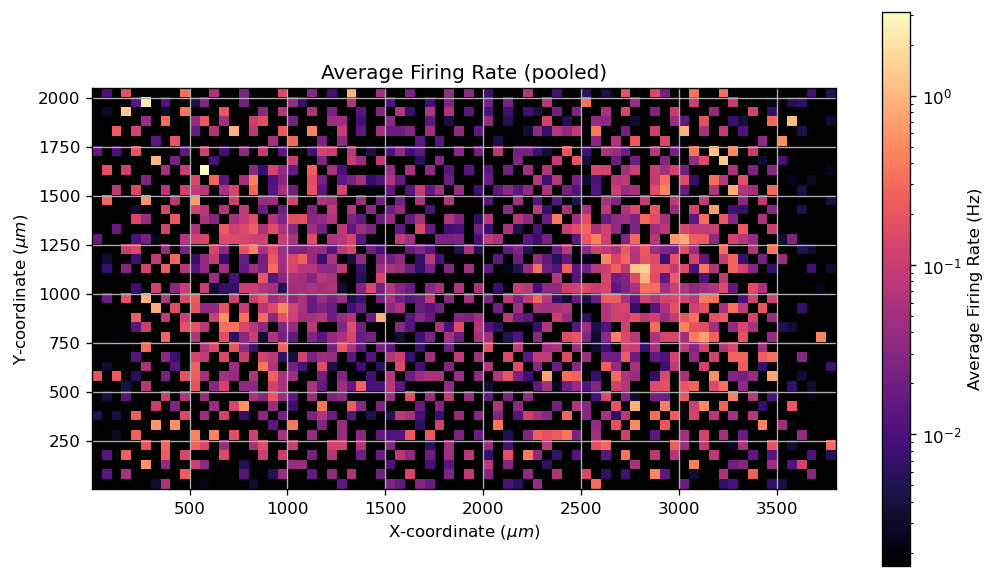

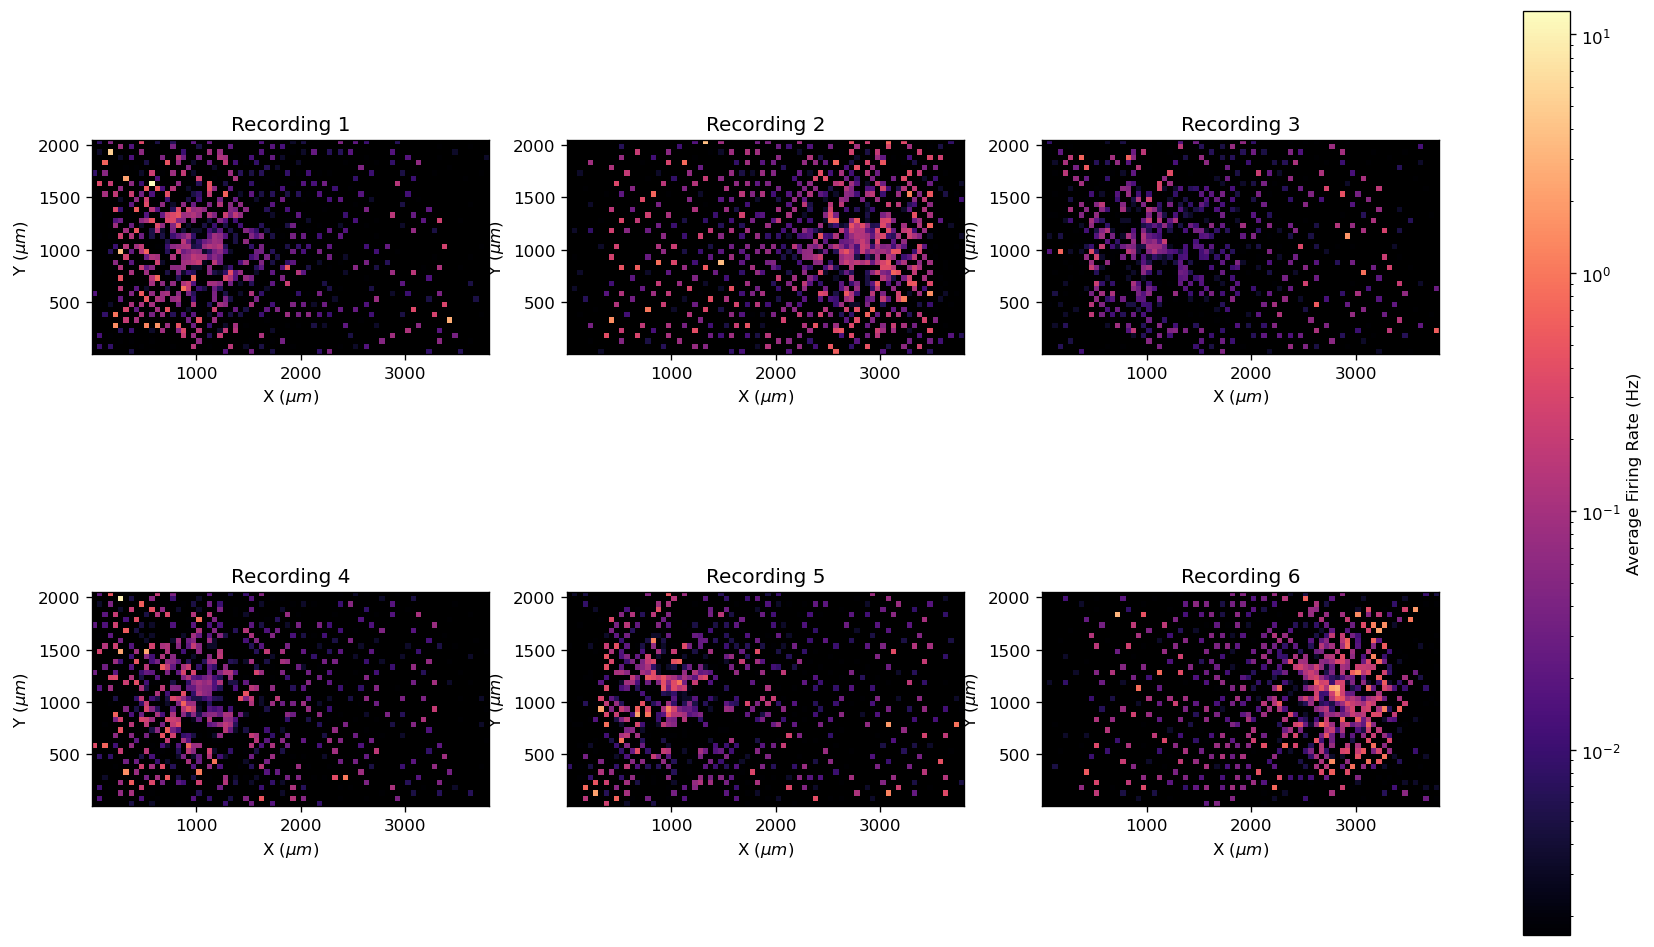

(<Figure size 1800x960 with 7 Axes>,
 array([[<AxesSubplot:title={'center':'Recording 1'}, xlabel='X ($\\mu m$)', ylabel='Y ($\\mu m$)'>,
         <AxesSubplot:title={'center':'Recording 2'}, xlabel='X ($\\mu m$)', ylabel='Y ($\\mu m$)'>,
         <AxesSubplot:title={'center':'Recording 3'}, xlabel='X ($\\mu m$)', ylabel='Y ($\\mu m$)'>],
        [<AxesSubplot:title={'center':'Recording 4'}, xlabel='X ($\\mu m$)', ylabel='Y ($\\mu m$)'>,
         <AxesSubplot:title={'center':'Recording 5'}, xlabel='X ($\\mu m$)', ylabel='Y ($\\mu m$)'>,
         <AxesSubplot:title={'center':'Recording 6'}, xlabel='X ($\\mu m$)', ylabel='Y ($\\mu m$)'>]],
       dtype=object))

In [7]:
lg = LayoutGridPlotter(ds)
lg.plot_grid_avghz_pooled(grid_size=50.0, interpolate=True)
lg.plot_grid_avghz_panel(grid_size=50.0, ncols=3, interpolate=True)


### Discrete Cosine Transform (DCT) Analysis

Once you have interpolated grids, the DCT analyzer helps quantify spatial frequencies. You can average DCT spectra across recordings, reconstruct dominant components, and inspect direction-specific frequency content.

In [ ]:
dct_an = DCTAnalyzer(ds)
interp_grids = dct_an.compute_interpolated_grids(grid_size=50.0)

avg_dct = DCTAnalyzer.average_dct([g.grid for g in interp_grids])
recon = DCTAnalyzer.reconstruct_from_top_components(
    avg_dct,
    stop_rank=3,
    start_rank=0,
    plot_distribution=True,
)
DCTAnalyzer.plot_reconstructed_grid(reconstructed=recon, res=interp_grids[0])
DCTAnalyzer.extract_and_plot_spatial_frequencies_from_dct(
    avg_dct,
    n_components_stop=3,
    n_components_start=0,
    array_dims=(3800, 2100),
    axis='x',
)


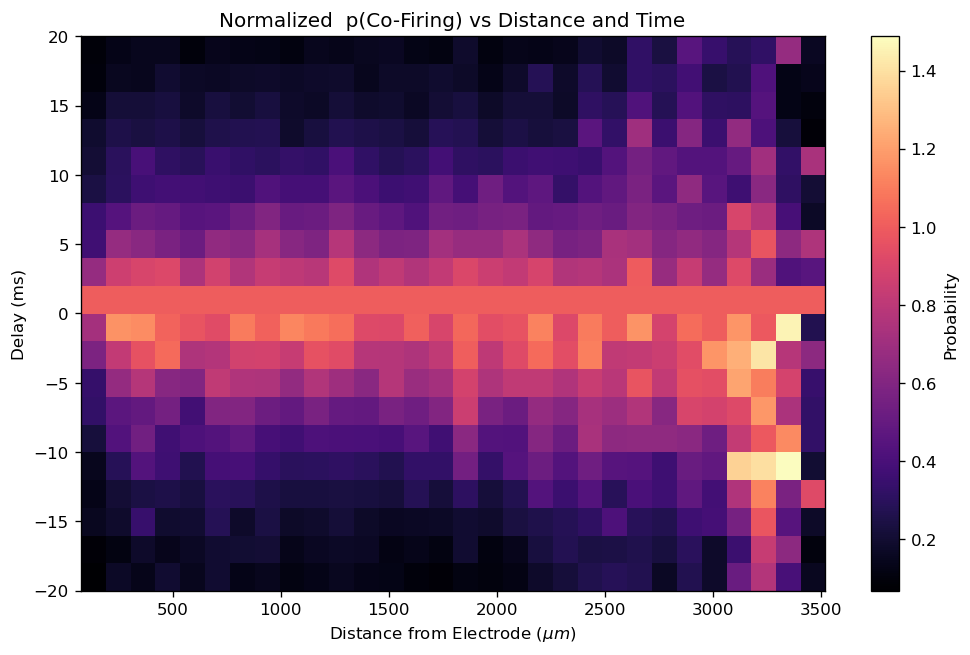

(<Figure size 1200x720 with 2 Axes>,
 <AxesSubplot:title={'center':'Normalized  p(Co-Firing) vs Distance and Time'}, xlabel='Distance from Electrode ($\\mu m$)', ylabel='Delay (ms)'>)

In [ ]:

cft_cfg = CofiringTemporalConfig(start_ms=-20, stop_ms=20, step_ms=1, normalize=True)
cft_analyzer = CofiringTemporalAnalyzer(ds, cft_cfg, selection_prep_config=prep_cfg)
cft_analyzer.plot_avg_cofiring_heatmap()